# DATASET WITH 'covid_year_timeline' and data only include 2017

Import Libraries

In [1]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly
from itertools import cycle
from time import time
import random

from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn import metrics #import silhouette_samples, silhouette_score
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer

import plotly.io as pio
pio.renderers
pio.renderers.default = "browser"

import Preprocess as pp
import Viz as viz

np.set_printoptions(precision = 3)

Set defaults

In [2]:
RANDOM_STATE = 42

df, column_trans, idx, df_orig = pp.preprocessData(data_from = 2017)

Split the dataset in X and y.

In [3]:
X = df.drop(columns=['log_scaled__total_sale_price'])
y = df['log_scaled__total_sale_price']

In [4]:
len(X.columns)

70

Showing how the original dataset is preprocessed and transformed.

In [4]:
column_trans

ColumnTransformer(transformers=[('onehot', OneHotEncoder(),
                                 ['physical_zip_code', 'physical_city']),
                                ('log_scaled',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<ufunc 'log1p'>)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['total_sale_price', 'assessed_building_value',
                                  'heated_area', 'unemploy_rate', 'covid_cases'...
                                  'crime', 'assessed_value_per_heated_area']),
                                ('mm_scaled', MinMaxScaler(),
                                 ['bath_fixtures', 'bath']),
                                ('std_scale', StandardScaler(),
                                 ['story_height', 'mort_rate',
                                  'pop_growth_rate', 'int_rate', 'supply',
                                  'demand', 'wake_supply_index',
                                  'wake_demand_index', 'year']),
                                ('passthru', 'passthrough',
                                 ['electric', 'gas', 'water', 'sewer', 'all',
                                  'is_covid', 'covid_year_timeline'])])

Showing the index of the columns in the dataframe based on preprocess methods.

In [5]:
idx

{'onehot': slice(0, 43, None),
 'log_scaled': slice(43, 53, None),
 'mm_scaled': slice(53, 55, None),
 'std_scale': slice(55, 64, None),
 'passthru': slice(64, 71, None),
 'remainder': slice(0, 0, None)}

### Prep the code with PCA reduced matrix
Use data after 2017 and 5 components for PCA


In [5]:
n = 5
pca_n = PCA(n_components=n, random_state=RANDOM_STATE)
pca_X = pca_n.fit_transform(X)
num_pc = pca_n.n_features_
names_pc = ['PC'+str(i) for i in range(1,n+1)]
pca_n_df = pd.DataFrame(pca_X, columns=names_pc)

pca_n_df.shape

(123764, 5)

In [6]:
pca_n_df.head()

,PC1,PC2,PC3,PC4,PC5
0,-3.785160,-0.721397,-0.353267,2.152700,-0.907762
1,-4.100519,-0.734797,1.590106,1.987697,-0.684340
2,-3.911557,-1.025741,1.461037,2.097274,0.120601
3,-3.638957,-1.205421,0.609320,2.199638,-0.702239
4,-3.843779,-0.899141,-2.112022,2.080641,0.170451


# DBSCAN (Density-based Spatial Clustering of Application with Noise)

Density based clustering can discover clusters of arbitrary shape by seperating dense regions from the low density regions (no need to pass the number of clusters). The algo can identity outliers as well.

eps: the maximum distance between two samples for one to be considered as in the neighborhood of the other. This is the most important parameter.

min_samples: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point, this includes the point itself.

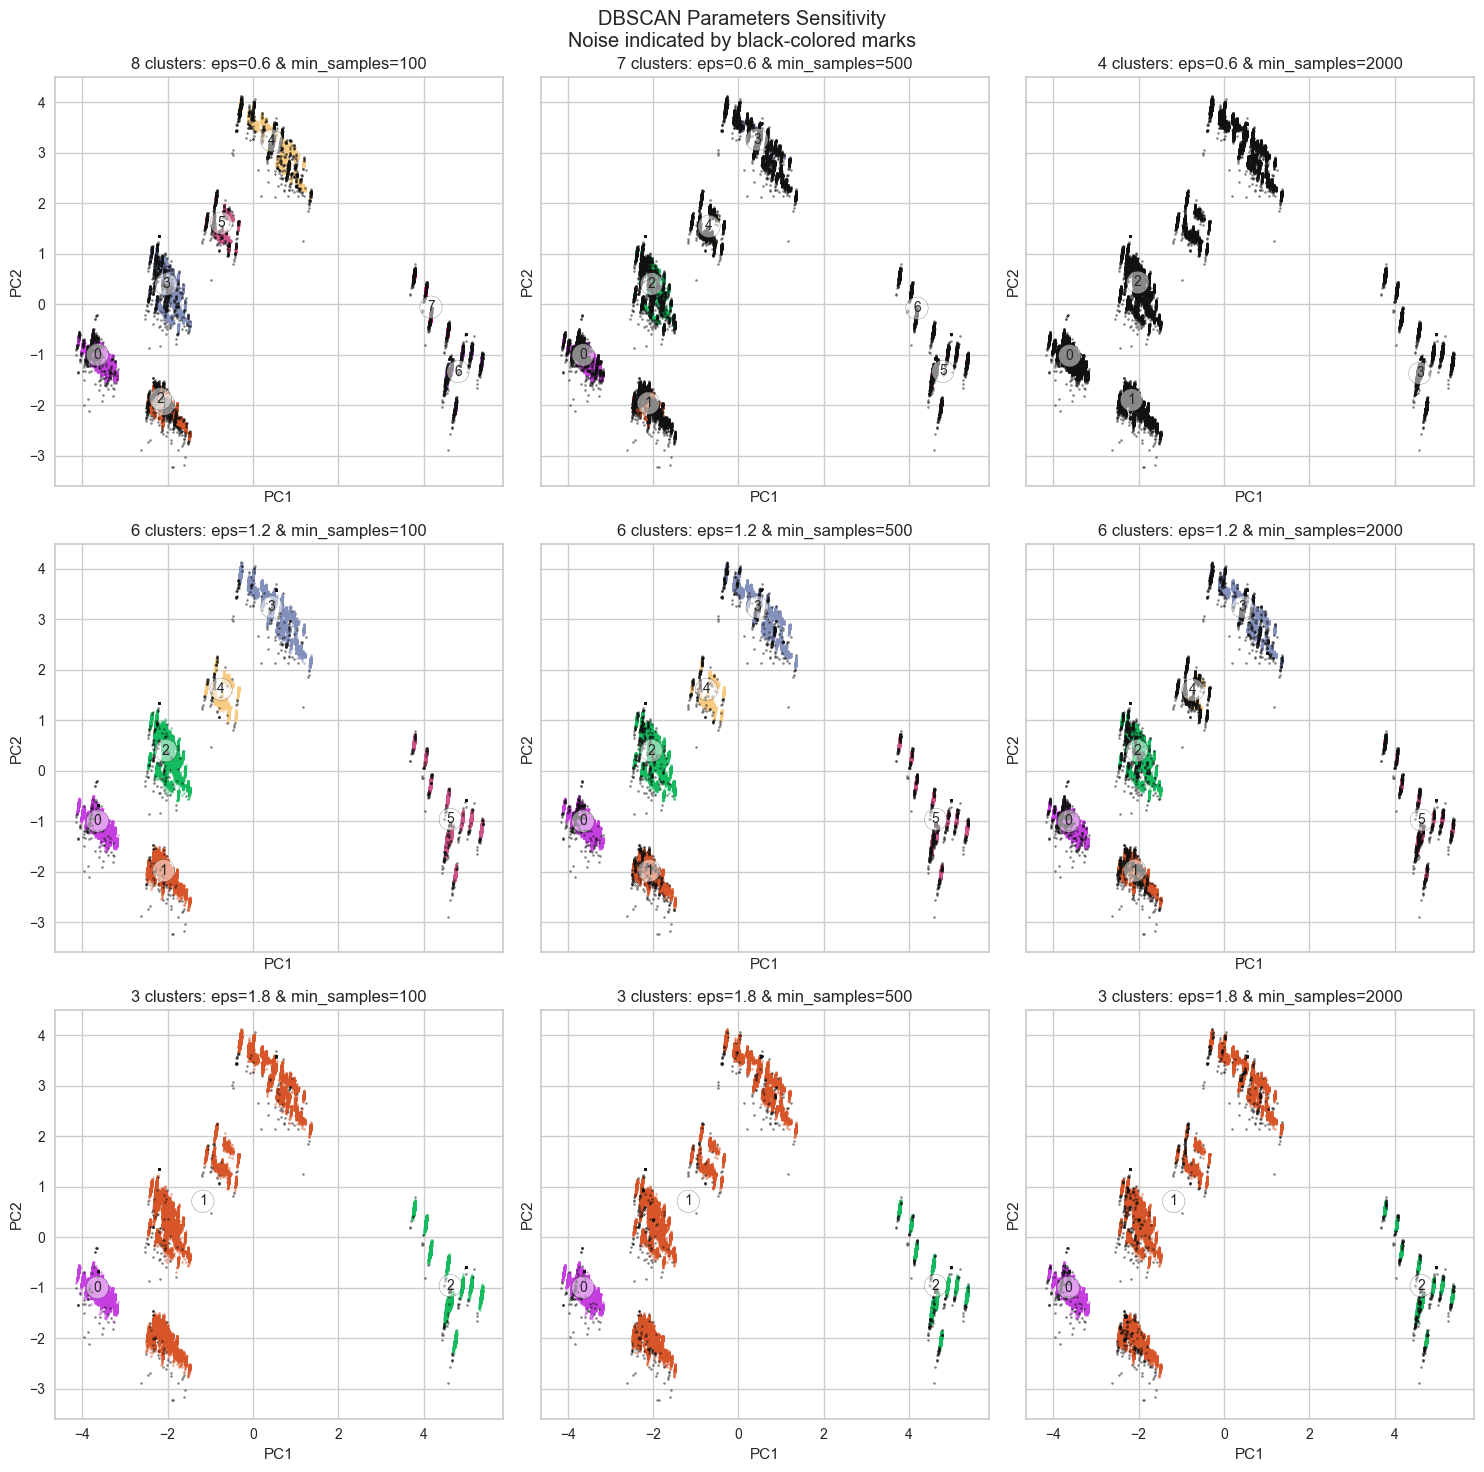

In [43]:
eps_lst = [0.6, 1.2, 1.8]
min_samples_lst = [100, 500, 2000]

fig, axes = plt.subplots(nrows=len(eps_lst), ncols=len(min_samples_lst), sharex = True, sharey = True, figsize=(15,15))

for i, eps in enumerate(eps_lst):
    for j, min_sample in enumerate(min_samples_lst):

        dbscan = DBSCAN(eps = eps, min_samples=min_sample).fit(pca_n_df)
        
        plotdf = pca_n_df.copy()
        plotdf['ClusterLabels'] = dbscan.labels_.astype(str)
        plotdf['ClusterLabels'] = 'Cluster ' + plotdf['ClusterLabels']
        plotdf['ClusterLabels'] = plotdf['ClusterLabels'].replace('Cluster -1', 'Noise')
        plotdf.sort_values(by='ClusterLabels', inplace=True)
        clusters = plotdf.ClusterLabels.unique()

        random.seed(0)
        get_colors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]
        colmaps = get_colors(len(clusters)) 
            
        for c, cluster in enumerate(clusters):
        #plotting each cluster
            df = plotdf[plotdf.ClusterLabels == cluster]
            color = 'k' if cluster == 'Noise' else colmaps[c]
            axes[i][j].scatter(data=df, x='PC1', y='PC2', c=color, label=cluster, s=2, alpha=0.5)
            if cluster != 'Noise':
                pc1_mean = df.PC1.mean()
                pc2_mean = df.PC2.mean()
                axes[i][j].annotate(cluster.replace('Cluster ', ''), (pc1_mean, pc2_mean), size='small', va='center', ha='center', bbox=dict(boxstyle='circle', fc= 'w', alpha=0.5))
        axes[i][j].set_xlabel('PC1')
        axes[i][j].set_ylabel('PC2')
        axes[i][j].title.set_text(str(len(clusters)-1)+' clusters: '+'eps='+str(eps)+' & min_samples='+str(min_sample))

fig.suptitle('DBSCAN Parameters Sensitivity\nNoise indicated by black-colored marks')
plt.tight_layout()

### Final DBSCAN parameters setting

In [64]:
# Final Model
eps=1.2
min_samples=100

dbscan = DBSCAN(eps = eps, min_samples=min_samples).fit(pca_n_df)

# df with cluster labels
plotdf = pca_n_df.copy()
plotdf['ClusterLabels_num'] = dbscan.labels_
plotdf['ClusterLabels'] = dbscan.labels_.astype(str)
plotdf['ClusterLabels'] = 'Cluster ' + plotdf['ClusterLabels']
plotdf['ClusterLabels'] = plotdf['ClusterLabels'].replace('Cluster -1', 'Noise')
plotdf.sort_values(by='ClusterLabels', inplace=True)
clusters = plotdf.ClusterLabels.unique()

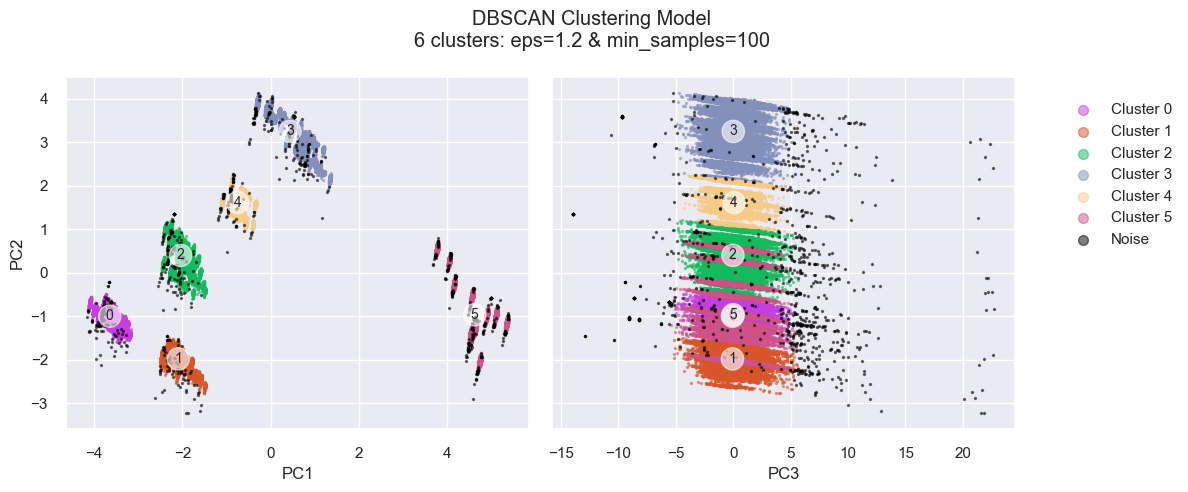

In [13]:
# fig config
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey = True, figsize=(12,5))

# list of color hex
random.seed(0)
get_colors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]
colmaps = get_colors(len(clusters)) 
colordict = {}

# plotting each cluster PC1 vs PC2 
for c, cluster in enumerate(clusters):
        df = plotdf[plotdf.ClusterLabels == cluster]
        color = '#000000' if cluster == 'Noise' else colmaps[c]
        colordict[cluster] = color # for 3d scatter use

        ax1.scatter(data=df, x='PC1', y='PC2', c=color, label=cluster, s=2, alpha=0.5)
        if cluster != 'Noise':
                pc1_mean = df.PC1.mean()
                pc2_mean = df.PC2.mean()
                ax1.annotate(cluster.replace('Cluster ', ''), (pc1_mean, pc2_mean), size='small', va='center', ha='center', bbox=dict(boxstyle='circle', fc= 'w', alpha=0.6))

        ax2.scatter(data=df, x='PC3', y='PC2', c=color, label=cluster, s=2, alpha=0.5)
        if cluster != 'Noise':
                pc3_mean = df.PC3.mean()
                pc2_mean = df.PC2.mean()
                ax2.annotate(cluster.replace('Cluster ', ''), (pc3_mean, pc2_mean), size='small', va='center', ha='center', bbox=dict(boxstyle='circle', fc= 'w', alpha=0.6))

ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax2.set_xlabel('PC3')

ax2.legend(loc=(1.1, 0.5), markerscale=5)

fig.suptitle('DBSCAN Clustering Model\n'+str(len(clusters)-1)+' clusters: '+'eps='+str(eps)+' & min_samples='+str(min_samples))
plt.tight_layout()

In [57]:
#Create 3D view of DBSCAN on PC1, PC2, and PC3

fig3d = px.scatter_3d(
    plotdf, 'PC1', 'PC2', 'PC3', 
    color='ClusterLabels', color_discrete_map=colordict,
    title='DBSCAN Clustering Model - 3d Space for PC1, PC2 & PC3'
    )
fig3d.update_traces(marker_size = 2)
fig3d.update_layout(legend=({'itemsizing': 'constant'}))
fig3d.show()
fig3d.write_html('DBSCAN_cluster3d.html')

In [65]:
# dataframe with original features, PC, and Cluster Labels

final_plot_df = pd.concat([plotdf.reset_index(drop=True), df_orig.reset_index(drop=True), X.reset_index(drop=True), y.reset_index(drop=True)], axis =1)

In [66]:
# selected columns
y_s = [
    'year', 'build_price', 'covid_cases', 'wake_supply_index', 'wake_demand_index', 
    'metals_price', 'demand', 'unemploy_rate', 'story_height', 'heated_area', 
    'PC1', 'PC2', 'PC3', 'PC4', 'PC5','log_scaled__total_sale_price']
thisdf = final_plot_df[final_plot_df.ClusterLabels != 'Noise']

In [71]:
thislst = y_s+['total_sale_price']

thisdf[thislst].groupby(thisdf['ClusterLabels']).median()

,year,build_price,covid_cases,wake_supply_index,wake_demand_index,metals_price,demand,unemploy_rate,story_height,heated_area,PC1,PC2,PC3,PC4,PC5,log_scaled__total_sale_price,total_sale_price
ClusterLabels,,,,,,,,,,,,,,,,,
Cluster 0,2017.0,142.900,0.0,72.669626,69.224265,213.3,157.9,3.9,2.00,2203.0,-3.675469,-0.979498,-0.153687,2.196642,0.104156,-0.152059,275000.0
Cluster 1,2018.0,151.400,0.0,63.474952,55.168041,244.1,146.3,3.5,1.88,2203.0,-2.110337,-1.987762,-0.178060,-1.776856,0.235262,-0.065485,291000.0
Cluster 2,2019.0,152.100,0.0,65.504122,46.036779,217.8,159.7,3.4,1.88,2188.0,-2.057793,0.451160,-0.103974,-0.704099,0.175921,-0.003622,303000.0
Cluster 3,2020.0,163.900,5298.0,72.986684,38.363982,205.2,169.9,5.4,1.88,2098.0,0.463637,3.298482,-0.072803,0.006877,0.245918,0.006449,305000.0
Cluster 4,2020.0,163.900,5298.0,72.986684,38.363982,205.2,169.9,5.4,2.00,2570.5,-0.804816,1.606447,-0.046856,-0.372108,0.200403,0.343028,380000.0
Cluster 5,2021.0,204.828,88933.0,96.829423,67.089410,354.9,152.0,4.2,1.88,2143.0,4.562714,-1.129231,-0.061452,0.382197,0.182072,0.255999,359000.0


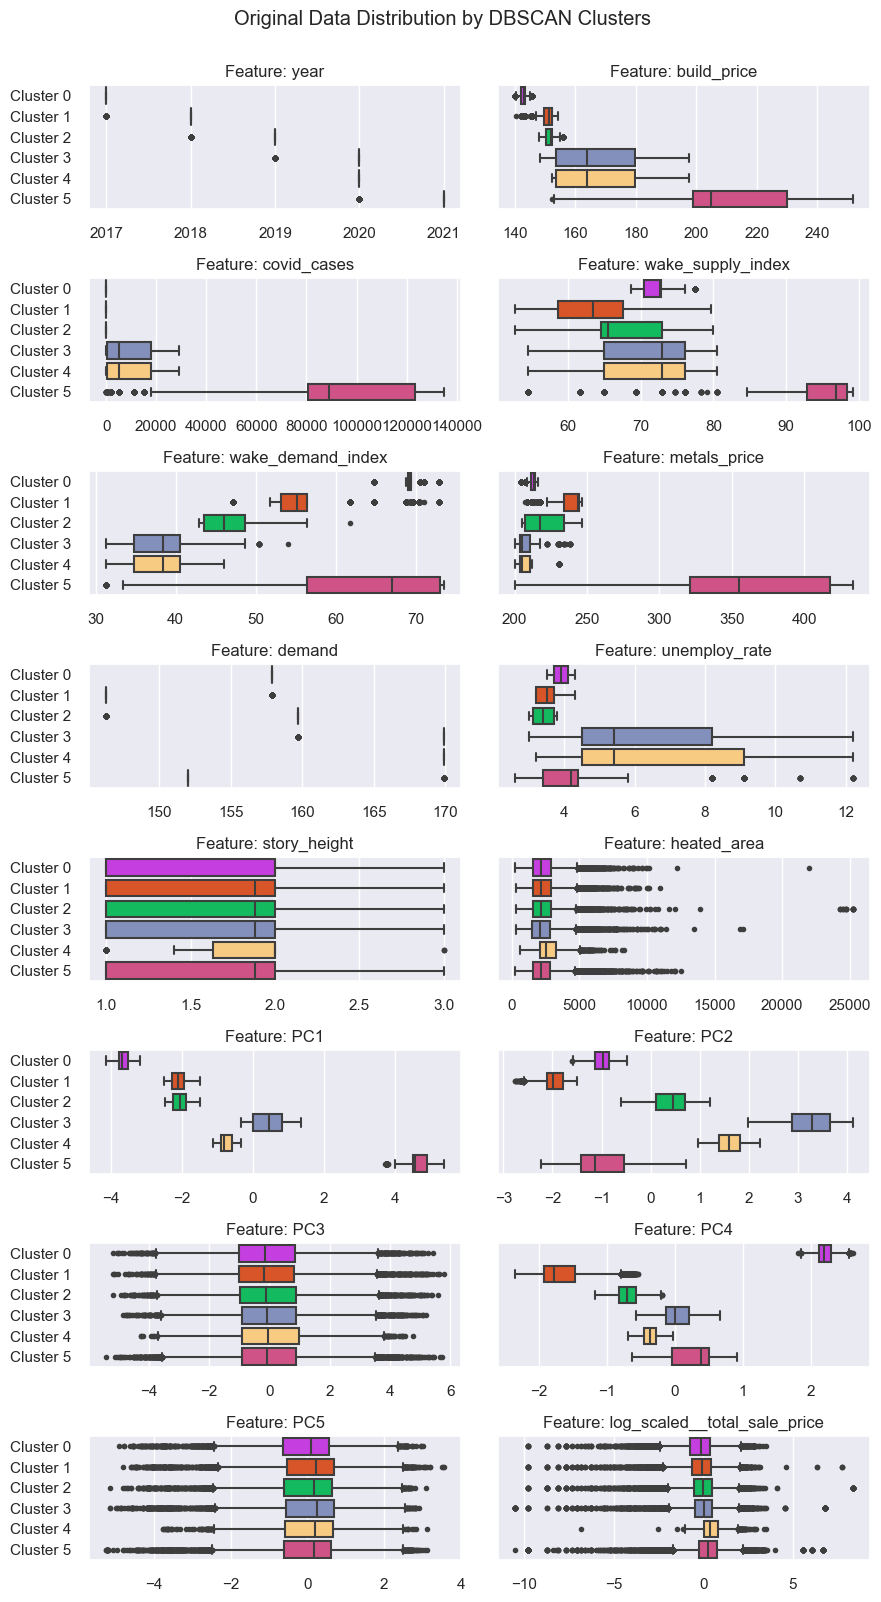

In [51]:
# Data Distribution 

fig, axes = plt.subplots(nrows=int(len(y_s)/2), ncols=1 if len(y_s)==1 else 2, figsize=(9, int(len(y_s)/2)*2), sharey=True)

flierprops = dict(marker='o', markersize=3)

for c, col in enumerate(y_s):

    i = int(c/2)
    j = 1 if (c+1) % 2 == 0 else 0

    sns.boxplot(
        ax=axes[i, j], # plot location
        y='ClusterLabels', x=col, data=thisdf, saturation=1, flierprops=flierprops, palette=colordict)#"husl") #PRGn

    axes[i][j].set_ylabel('')
    axes[i][j].set_xlabel('')
    axes[i][j].title.set_text('Feature: '+col)

fig.suptitle('Original Data Distribution by DBSCAN Clusters', y=1)
fig.tight_layout(h_pad=1, w_pad=2)


C:\Users\choit\AppData\Local\Temp\ipykernel_26432\2705832449.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\choit\AppData\Local\Temp\ipykernel_26432\2705832449.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



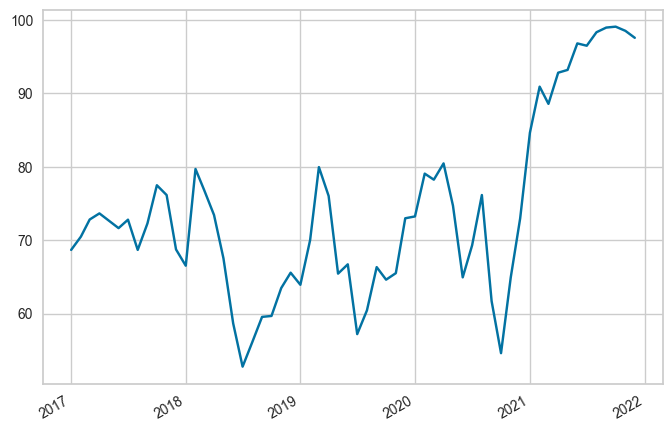

In [137]:
# Plot to check data over time on original dataframe

thisdf.sort_values('deed_date', inplace=True)
thisdf['deed_date'] = pd.to_datetime(thisdf['deed_date'] )

fig, ax = plt.subplots()
ax.plot(thisdf.deed_date, thisdf.wake_supply_index)
ax.xaxis_date()
fig.autofmt_xdate()

plt.show()

In [ ]:
# https://stackoverflow.com/questions/37489874/how-do-i-put-a-circle-with-annotation-in-matplotlib

In [59]:
# https://www.researchgate.net/figure/Results-from-PAM-clustering-of-DEGs-A-PCA-analysis-showing-the-three-defined-clusters_fig3_327575230

# Agglomerative Clustering

Not supported for ward, complete, and average linkage, return as Memory Error due to large data size.
By definition, the algorithm needs O(n²) memory and O(n³) runtime.

In [22]:
agglm = AgglomerativeClustering(
    distance_threshold=3.5, n_clusters=None,
    #n_clusters=6, 
    linkage="single"
    ).fit(pca_n_df.to_numpy())
#ward, complete, avarage - Memory Error
#single no problem
print('Number of Obs:', len(pca_n_df))
print('Number of leaves', agglm.n_leaves_)
print('Number of Clusters:', agglm.n_clusters_)

Number of Obs: 123764
Number of leaves 123764
Number of Clusters: 6


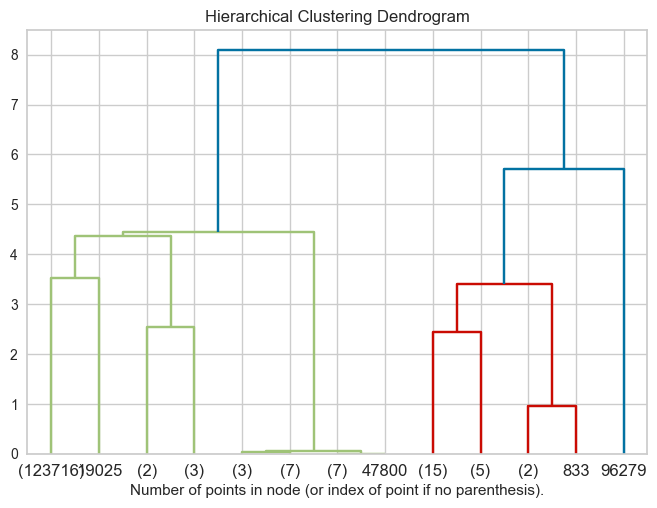

In [23]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(agglm, truncate_mode="level", p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

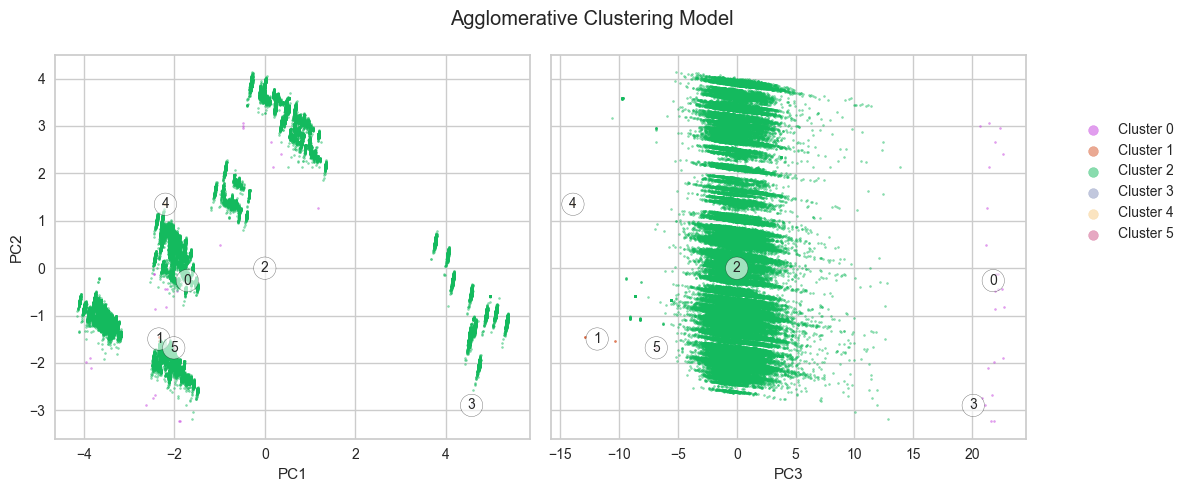

In [19]:
# df with cluster labels
plotdf = pca_n_df.copy()
plotdf['ClusterLabels'] = agglm.labels_
plotdf['ClusterLabels'] = agglm.labels_.astype(str)
plotdf['ClusterLabels'] = 'Cluster ' + plotdf['ClusterLabels']
plotdf['ClusterLabels'] = plotdf['ClusterLabels'].replace('Cluster -1', 'Noise')
plotdf.sort_values(by='ClusterLabels', inplace=True)
clusters = plotdf.ClusterLabels.unique()

# fig config
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey = True, figsize=(12,5))

# list of color hex
random.seed(0)
get_colors = lambda n: ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]
colmaps = get_colors(len(clusters)) 
colordict = {}

# plotting each cluster PC1 vs PC2 
for c, cluster in enumerate(clusters):
        df = plotdf[plotdf.ClusterLabels == cluster]
        color = '#000000' if cluster == 'Noise' else colmaps[c]
        colordict[cluster] = color # for 3d scatter use

        ax1.scatter(data=df, x='PC1', y='PC2', c=color, label=cluster, s=2, alpha=0.5)
        if cluster != 'Noise':
                pc1_mean = df.PC1.mean()
                pc2_mean = df.PC2.mean()
                ax1.annotate(cluster.replace('Cluster ', ''), (pc1_mean, pc2_mean), size='small', va='center', ha='center', bbox=dict(boxstyle='circle', fc= 'w', alpha=0.6))

        ax2.scatter(data=df, x='PC3', y='PC2', c=color, label=cluster, s=2, alpha=0.5)
        if cluster != 'Noise':
                pc3_mean = df.PC3.mean()
                pc2_mean = df.PC2.mean()
                ax2.annotate(cluster.replace('Cluster ', ''), (pc3_mean, pc2_mean), size='small', va='center', ha='center', bbox=dict(boxstyle='circle', fc= 'w', alpha=0.6))

ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax2.set_xlabel('PC3')

ax2.legend(loc=(1.1, 0.5), markerscale=5)

fig.suptitle('Agglomerative Clustering Model with distance threshold 3.5')
plt.tight_layout()